# Exposure Time Predictor
Use observing conditions (sampled at earliest a few min ago, and many older points) to predict exposure time for next exposure at a new position, airmass, etc

### Features vs. Answers
 * Features: obsdb statistics since that's what see when observing
 * Answers: expfactor using depth in CP images as that's what actually wan to achieve, which is NOT expfactor column in the obsdb db! 

### Prediction
expfactor (exptime divided by a given band's nominal)

### Features

### Notes
 * supervised
 * online or batch?
 * regression classifier, model based
 * performance: RMSE
 * scaling of features: expfactor 
 * cleaning
  - transp > 0.9 for 50 consecutive exposures

# Starting where "addylabel_and_splittraintest" left off

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

REPO_DIR= os.path.join(os.environ['HOME'],
                       'PhdStudent/Research/desi/ml_data/')
DB_DIR= os.path.join(REPO_DIR,'obsbot/obsdb')

In [17]:
# from exptime_predictor.data import main
# df_train= main()

In [19]:
from exptime_predictor.data import GetData,Clean,Split_TrainTest
d= GetData(REPO_DIR)
d.fetch()
df = d.load()

df= Clean().keep_science_exposures(df)
df= Clean().add_night_obs(df)
df= Clean().seamless_hr_obs(df)
#df= Clean().drop_bad_transp(df, thresh=0.9)
df= Clean().drop_nights_wfew_exposures(df, nexp=20)

#df= AddYlabel().use_obsdb_expfactor(df)
#df= AddYlabel().clean(df)

df_train,df_test= Split_TrainTest().random_sampling(df)

UNIX cmd: git pull origin master
UNIX cmd: git checkout 84d63bb9aa33
Reading sqlite db: /Users/kaylan1/PhdStudent/Research/desi/ml_data/obsbot/obsdb/decam.sqlite3
Has tables:  [('django_migrations',), ('sqlite_sequence',), ('obsdb_measuredccd',)]
executing query: select * from obsdb_measuredccd


In [20]:
hr_thresh= 150000.
isEvening= df_train.loc[:,'hr_obs'] > hr_thresh
isEvening.shape
df_train.loc[isEvening,'hr_obs']= df_train.loc[isEvening,'hr_obs'] - 240000.

In [3]:
d= Data(REPO_DIR)
d.fetch_data()
df = d.load_data()

df= Clean().keep_science_exposures(df)
df= Clean().add_night_obs(df)
df= Clean().drop_bad_transp(df, thresh=0.9)
# TODO: remove duplicated expids b/c have > 1000 exposures on some nights
# ALWAYS last step
df= Clean().drop_nights_wfew_exposures(df, nexp=20)

df= AddYlabel().use_obsdb_expfactor(df)
df= AddYlabel().clean(df)

df_train,df_test= Split_TrainTest().random_sampling(df)

UNIX cmd: git pull origin master
UNIX cmd: git checkout 84d63bb9aa33
Reading sqlite db: /Users/kaylan1/PhdStudent/Research/desi/ml_data/obsbot/obsdb/decam.sqlite3
Has tables:  [('django_migrations',), ('sqlite_sequence',), ('obsdb_measuredccd',)]
executing query: select * from obsdb_measuredccd


# Look at Training

In [29]:
import seaborn as sns
sns.set_context("notebook")

ModuleNotFoundError: No module named 'seaborn'

In [23]:
'night_obs' in df_train.columns

True

In [26]:
#df_train.plot.line('seeing')
nights= (df_train
         .groupby('night_obs')
#          .loc[:,('seeing','night_obs')]
        )


In [45]:
a.values

array([1065,  753,  507,  484,  466,  461,  413,  299,  281,  267,  267,
        264,  235,  231,  229,  215,  188,  186,  186,  180,  163,  150,
        131,  122,  116,  115,  111,  108,   88,   86,   85,   80,   72,
         44,   40,   27,   25,   24,   24,   21])

In [10]:
# df_train.loc[:,('seeing','night_obs')].groupby('night_obs').head()
a=df_train['night_obs'].value_counts()
nights= a.index[ (a.values > 90) & (a.values < 240)]
nights

Int64Index([20160606, 20160406, 20160721, 20150329, 20160301, 20160723,
            20160608, 20170331, 20151226, 20170405, 20161220, 20141230],
           dtype='int64')

In [60]:
isNight= df_train.loc[:,'night_obs'] == night
a=df_train.loc[isNight]
a.sort_values('mjd_obs').head()

,id,filename,extension,expnum,exptime,mjd_obs,airmass,racenter,deccenter,rabore,...,affine_dxx,affine_dxy,affine_dy,affine_dyx,affine_dyy,affine_x0,affine_y0,night_obs,hr_obs,tneed
21525,21574,/home4/images/fits/2014B-0404/DECam_00647995.f...,N4,647995,125.0,57886.979783,1.28,163.989423,7.215896,163.996996,...,1.000272,-0.001757,-0.084344,0.001393,0.999763,924.0,1948.0,20170513,233053.278,260.077333
21526,21575,/home4/images/fits/2014B-0404/DECam_00647996.f...,N4,647996,175.0,57886.981590,1.25,167.643463,4.159896,167.650996,...,1.000163,-0.001675,-0.257205,0.001481,0.999850,924.0,1948.0,20170513,233329.419,387.015180
21527,21576,/home4/images/fits/2014B-0404/DECam_00647997.f...,N4,647997,125.0,57886.984065,1.20,170.388483,-0.206104,170.395996,...,0.999984,-0.001526,-0.217454,0.001496,1.000228,924.0,1948.0,20170513,233703.179,192.178170
21528,21577,/home4/images/fits/2014B-0404/DECam_00647998.f...,N4,647998,125.0,57886.985845,1.23,173.143486,1.207896,173.151000,...,1.000484,-0.000883,-0.143734,0.001222,0.999964,924.0,1948.0,20170513,233936.991,211.674244
21543,21592,/home4/images/fits/2014B-0404/DECam_00648013.f...,N4,648013,125.0,57887.017915,1.15,182.447470,-4.387104,182.455004,...,1.000058,-0.001227,0.132177,0.001196,0.999989,924.0,1948.0,20170513,2547.837,151.786221


In [20]:
cols= ['night_obs','hr_obs','mjd_obs','sky','seeing','transparency']
X= df_train.loc[:,cols].values

ix= {}
for i,col in enumerate(cols):
    ix[col]=i
X.shape

(9881, 6)

In [31]:
a=df_train['night_obs'].value_counts()
nights= a.index[ (a.values > 50) & (a.values < 200)]
nights= nights.values
nights

array([20151010, 20151226, 20161113, 20170418, 20160813, 20151027,
       20170405, 20141230, 20170504, 20170512, 20160720, 20161228,
       20160111, 20141229, 20161010])

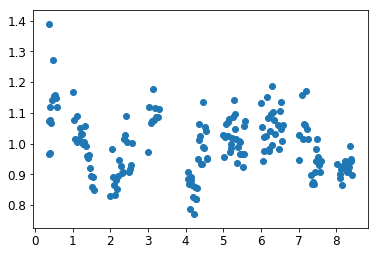

In [23]:
oneNight= X[:,ix['night_obs']] == nights[0]
x= X[oneNight, ix['hr_obs']]
y= X[oneNight, ix['seeing']]
plt.scatter(x,y)

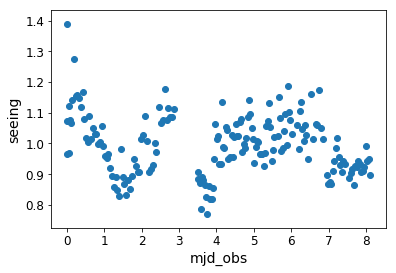

In [24]:
def order_mjd(mjd_one_night):
    """mjd_one_night: numpy array of one nights mjd_obs values"""
    mjd= mjd_one_night.copy()
    mjd -= mjd[0]
    isEvening= mjd > 1
    isMorning= isEvening == False
    if np.any(isEvening):
        mjd_evening_start= mjd[isEvening].min()
        mjd_morning_start= mjd[isEvening].max()
        mjd[isEvening] -=  mjd_evening_start
        mjd[isMorning] +=  mjd_morning_start - mjd_evening_start
    # hrs not fraction of day
    return mjd * 24.

mjd= order_mjd( X[oneNight, ix['mjd_obs']] )
#mjd= X[oneNight, ix['mjd_obs']] - X[oneNight, ix['mjd_obs']][0]
# mjd[ mjd > 1]= mjd[ mjd > 1] - mjd[ mjd > 1].max()
x= mjd
y= X[oneNight, ix['seeing']]
plt.scatter(x,y)
plt.xlabel('mjd_obs')
plt.ylabel('seeing')

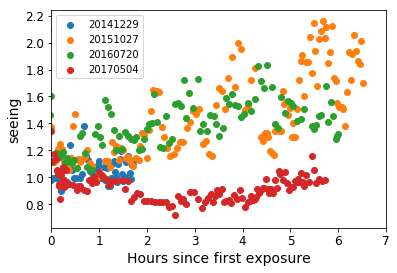

In [36]:
# one night per year and 100 < num_exp < 180
# nights_each_year= [20160607, 20170512, 20141227, 20151226]
nights_each_year= [20141229, 20151027, 20160720, 20170504]
# for night in nights:
for night in nights_each_year:
    oneNight= X[:,ix['night_obs']] == night
    mjd= order_mjd( X[oneNight, ix['mjd_obs']] )
    y= X[oneNight, ix['seeing']]
    plt.scatter(mjd,y,label=night)
    plt.legend(loc=0)
    plt.xlabel('Hours since first exposure')
    plt.ylabel('seeing')
    plt.xlim(0,7)

In [49]:
df_train.columns

Index(['id', 'filename', 'extension', 'expnum', 'exptime', 'mjd_obs',
       'airmass', 'racenter', 'deccenter', 'rabore', 'decbore', 'band', 'ebv',
       'zeropoint', 'transparency', 'seeing', 'sky', 'expfactor', 'camera',
       'dx', 'dy', 'md5sum', 'bad_pixcnt', 'readtime', 'nmatched', 'object',
       'passnumber', 'tileebv', 'tileid', 'obstype', 'affine_dx', 'affine_dxx',
       'affine_dxy', 'affine_dy', 'affine_dyx', 'affine_dyy', 'affine_x0',
       'affine_y0', 'night_obs', 'hr_obs'],
      dtype='object')

In [51]:
cols= ['night_obs','hr_obs','mjd_obs',
       'seeing','airmass','nmatched','transparency']
X= df_train.loc[:,cols].values

ix= {}
for i,col in enumerate(cols):
    ix[col]=i
X.shape

(9881, 7)

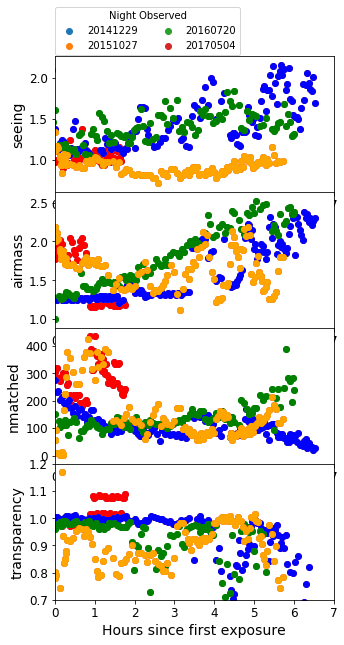

In [58]:
# one night per year and 100 < num_exp < 180
stats= ['seeing','airmass','nmatched','transparency']
lims= dict(seeing= None,
           transparency=[0.7,1.2],
           airmass=None,
           nmatched=None)

fig,ax= plt.subplots(len(stats),1,figsize=(5,10))
plt.subplots_adjust(hspace=0)

for night,color in zip(nights_each_year,
                       ['r','b','g','orange']):
    oneNight= X[:,ix['night_obs']] == night
    mjd= order_mjd( X[oneNight, ix['mjd_obs']] )
    for iax,stat in enumerate(stats):
        y= X[oneNight, ix[stat]]
        ax[iax].scatter(mjd,y,label= night)
        plot_kwargs= dict(facecolors='none', edgecolors=color,
                          rasterized=True,alpha=1.)
        plot_kwargs.update(c=color)
        ax[iax].scatter(mjd,y, **plot_kwargs)
    leg= ax[0].legend(loc=(0,1.01),ncol=2,title='Night Observed')
    xlab= ax[-1].set_xlabel('Hours since first exposure')
    for iax,stat in enumerate(stats):
        ylab= ax[iax].set_ylabel(stat)
        if lims[stat]:
            ax[iax].set_ylim(lims[stat])
        ax[iax].set_xlim([0,7])
    
plt.savefig('weather.png', bbox_extra_artists=[leg,xlab,ylab], 
            bbox_inches='tight',dpi=150)

In [6]:
corr_matrix = df_train.corr()
corr_matrix["tneed"].sort_values(ascending=False)

tneed           1.000000
expfactor       0.902668
seeing          0.643963
exptime         0.628697
airmass         0.399241
passnumber      0.329754
tileid          0.306951
decbore         0.249492
deccenter       0.247752
ebv             0.229465
tileebv         0.183906
nmatched        0.145837
affine_x0       0.129636
affine_y0       0.129636
affine_dyy      0.129617
affine_dxx      0.129360
hr_obs          0.071310
id              0.032234
affine_dyx      0.026542
affine_dx       0.025898
mjd_obs         0.004689
transparency    0.004252
expnum          0.001714
rabore         -0.018325
racenter       -0.021679
affine_dy      -0.026162
sky            -0.036005
night_obs      -0.047957
affine_dxy     -0.050608
dx             -0.075441
dy             -0.075899
zeropoint      -0.318887
bad_pixcnt           NaN
readtime             NaN
Name: tneed, dtype: float64

In [12]:
df_train[['bad_pixcnt','readtime']].describe()

,bad_pixcnt,readtime
count,8681.0,8681.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [27]:
df_train= df_train.drop(['bad_pixcnt','readtime'],axis=1)

In [28]:
cols= ['mjd_obs','transparency','expnum']
df_train= df.drop(cols,axis=1)

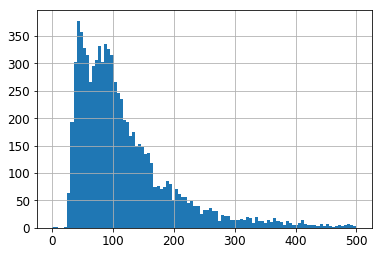

count    8321.000000
mean      118.911160
std        80.019627
min        24.580378
25%        63.289703
50%        96.857162
75%       147.672522
max       496.470644
Name: tneed, dtype: float64

# Prepare the data for Machine Learning algorithms

In [29]:
df = df_train.drop("tneed", axis=1)
df_labels = df_train["tneed"].copy()

In [85]:
#len(housing.dropna(subset=["total_bedrooms"])),len(housing)

(16354, 16512)

In [42]:
df['obstype'].value_counts()

[autoreload of exptime_predictor.data failed: Traceback (most recent call last):
  File "/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>",

object    8681
Name: obstype, dtype: int64

In [41]:
df['object'].value_counts()

DeCaLS            24
hex check         15
                  12
test              11
junk              11
DECaLS_Start_z    11
pointing          10
hexapod update     3
Hexapod update     3
DECaLS_15163_z     2
DECaLS_7110_r      2
DECaLS_33759_r     2
DECaLS_22892_g     2
DECaLS_22674_g     2
DECaLS_30992_z     2
DECaLS_15285_r     2
DECaLS_26573_g     2
DECaLS_44924_z     2
DECaLS_23802_r     2
DECaLS_15340_g     2
DECaLS_17887_z     2
DECaLS_1183_g      2
DECaLS_15164_z     2
DECaLS_29823_g     2
DECaLS_1236_z      2
DECaLS_5096_z      2
DECaLS_29094_g     2
DECaLS_33799_g     2
DECaLS_235_z       2
DECaLS_43415_r     2
                  ..
DECaLS_1181_z      1
DECaLS_46878_r     1
DECaLS_26516_g     1
DECaLS_34967_z     1
DECaLS_31735_g     1
DECaLS_10853_g     1
DECaLS_19168_z     1
DECaLS_186_r       1
DECaLS_9653_g      1
DECaLS_3323_z      1
DECaLS_9775_z      1
DECaLS_17938_z     1
DECaLS_25469_r     1
DECaLS_23757_z     1
DECaLS_23719_z     1
DECaLS_41516_z     1
DECaLS_1295_g

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8681 entries, 106 to 28534
Data columns (total 35 columns):
id            8681 non-null int64
filename      8681 non-null object
extension     8681 non-null object
exptime       8681 non-null float64
airmass       8681 non-null float64
racenter      8681 non-null float64
deccenter     8681 non-null float64
rabore        8681 non-null float64
decbore       8681 non-null float64
band          8681 non-null object
ebv           8681 non-null float64
zeropoint     8681 non-null float64
seeing        8681 non-null float64
sky           8681 non-null float64
expfactor     8681 non-null float64
camera        8681 non-null object
dx            8681 non-null float64
dy            8681 non-null float64
md5sum        8681 non-null object
nmatched      8681 non-null int64
object        8681 non-null object
passnumber    8681 non-null int64
tileebv       8681 non-null float64
tileid        8681 non-null int64
obstype       8681 non-null object
affin

In [52]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# text to integers
label_encoder = LabelEncoder()
encoded = label_encoder.fit_transform(df['band'])
print(encoded)
# integers to hot/cold vectors
hot_encoder= OneHotEncoder()
hot_encoded = hot_encoder.fit_transform(encoded.reshape(-1,1))
hot_encoded

[2 2 2 ..., 0 0 1]


<8681x3 sparse matrix of type '<class 'numpy.float64'>'
	with 8681 stored elements in Compressed Sparse Row format>

# Select and train a model 

In [114]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Compare against the actual values:

In [116]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [117]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [118]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [119]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018973

In [120]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [121]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [123]:
cross_val_score?

In [122]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [124]:
LinearR

[ -4.93253574e+09  -4.46604419e+09  -5.24814577e+09  -5.00719015e+09
  -5.05884059e+09  -5.71253188e+09  -4.92377176e+09  -4.90775608e+09
  -5.68071094e+09  -5.07262895e+09]


In [126]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Mean: 71379.0744771
Standard deviation: 2458.31882043


In [127]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [128]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [129]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [130]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard deviation: 2301.87380392


In [131]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [86]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [132]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [133]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [134]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [140]:
cvres.keys()

dict_keys(['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params'])

In [141]:
cvres = grid_search.cv_results_
for mean_score,std_score, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),np.sqrt(std_score), params)

63825.0479302 10773.5494371 {'max_features': 2, 'n_estimators': 3}
55643.8429091 11392.1873564 {'max_features': 2, 'n_estimators': 10}
53380.6566859 12623.9806065 {'max_features': 2, 'n_estimators': 30}
60959.1388585 13000.1105598 {'max_features': 4, 'n_estimators': 3}
52740.5841667 11307.0704473 {'max_features': 4, 'n_estimators': 10}
50374.1421461 10999.7030522 {'max_features': 4, 'n_estimators': 30}
58661.2866462 13726.7206754 {'max_features': 6, 'n_estimators': 3}
52009.9739798 12103.567305 {'max_features': 6, 'n_estimators': 10}
50154.1177737 11329.5185722 {'max_features': 6, 'n_estimators': 30}
57865.3616801 11075.5701016 {'max_features': 8, 'n_estimators': 3}
51730.0755087 11803.6128258 {'max_features': 8, 'n_estimators': 10}
49694.8514333 10437.4105116 {'max_features': 8, 'n_estimators': 30}
62874.4073931 13778.666248 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54561.9398157 12559.5161223 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59416.6463145 8

In [91]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.055782,0.003593,-4.073637e+09,-1.107354e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.963584e+09,...,-4.194135e+09,-1.116843e+09,-3.906732e+09,-1.112813e+09,-4.169669e+09,-1.129842e+09,0.000631,0.000542,1.160694e+08,1.927217e+07
1,0.172177,0.008357,-3.096237e+09,-5.813707e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.070368e+09,...,-3.124982e+09,-5.780873e+08,-2.865117e+09,-5.713421e+08,-3.169914e+09,-5.797944e+08,0.002452,0.000872,1.297819e+08,6.782553e+06
2,0.549370,0.024622,-2.849495e+09,-4.394633e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.697829e+09,...,-2.943808e+09,-4.374429e+08,-2.619893e+09,-4.374715e+08,-2.968460e+09,-4.451903e+08,0.031675,0.001817,1.593649e+08,2.961109e+06
3,0.108659,0.003603,-3.716017e+09,-9.850011e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.729600e+09,...,-3.736527e+09,-9.172986e+08,-3.404974e+09,-1.035901e+09,-3.914186e+09,-9.711998e+08,0.005413,0.000532,1.690029e+08,4.047487e+07
4,0.345844,0.010100,-2.781569e+09,-5.160154e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.667093e+09,...,-2.891599e+09,-4.960301e+08,-2.613393e+09,-5.422542e+08,-2.949550e+09,-5.158794e+08,0.005767,0.001052,1.278498e+08,1.498960e+07
5,0.890049,0.025157,-2.537554e+09,-3.878685e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.387199e+09,...,-2.663178e+09,-3.789712e+08,-2.397951e+09,-4.036920e+08,-2.649850e+09,-3.846171e+08,0.040411,0.001709,1.209935e+08,8.424973e+06
6,0.134878,0.003163,-3.441147e+09,-9.030212e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",14,-3.119576e+09,...,-3.587747e+09,-9.360639e+08,-3.331544e+09,-9.025026e+08,-3.577062e+09,-8.612945e+08,0.003447,0.000230,1.884229e+08,2.639683e+07
7,0.441237,0.009476,-2.705037e+09,-5.014210e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.553481e+09,...,-2.762945e+09,-4.996537e+08,-2.519522e+09,-4.989516e+08,-2.906270e+09,-5.063617e+08,0.026262,0.001327,1.464963e+08,3.357661e+06
8,1.293729,0.025095,-2.515436e+09,-3.840197e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.371924e+09,...,-2.607962e+09,-3.805596e+08,-2.351220e+09,-3.856159e+08,-2.662399e+09,-3.904866e+08,0.043359,0.000991,1.283580e+08,3.796810e+06
9,0.154177,0.003283,-3.348400e+09,-8.884890e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",13,-3.351347e+09,...,-3.396841e+09,-8.596460e+08,-3.131753e+09,-8.893698e+08,-3.509451e+09,-9.146734e+08,0.002721,0.000364,1.226683e+08,2.730057e+07


In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff6886eb978>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff6886eb630>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [93]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50798.3025423 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50776.7360494 {'max_features': 3, 'n_estimators': 75}
50682.7075546 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50472.6107336 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


In [94]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [95]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813418, 'median_income'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.073344235516012421, 'longitude'),
 (0.062909070482620302, 'latitude'),
 (0.056419179181954007, 'rooms_per_hhold'),
 (0.053351077347675809, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.0028564746373201579, 'NEAR OCEAN'),
 (0.0019604155994780701, 'NEAR BAY'),
 (6.0280386727365991e-05, 'ISLAND')]

In [96]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [97]:
final_rmse

47766.003966433083

## Model persistence using joblib

In [99]:
my_model = full_pipeline_with_predictor

In [100]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF